Starting Hx-only simulation (decode Z errors) with 5000 shots per point...
Simulating L=3...
Simulating L=9...
Simulating L=15...


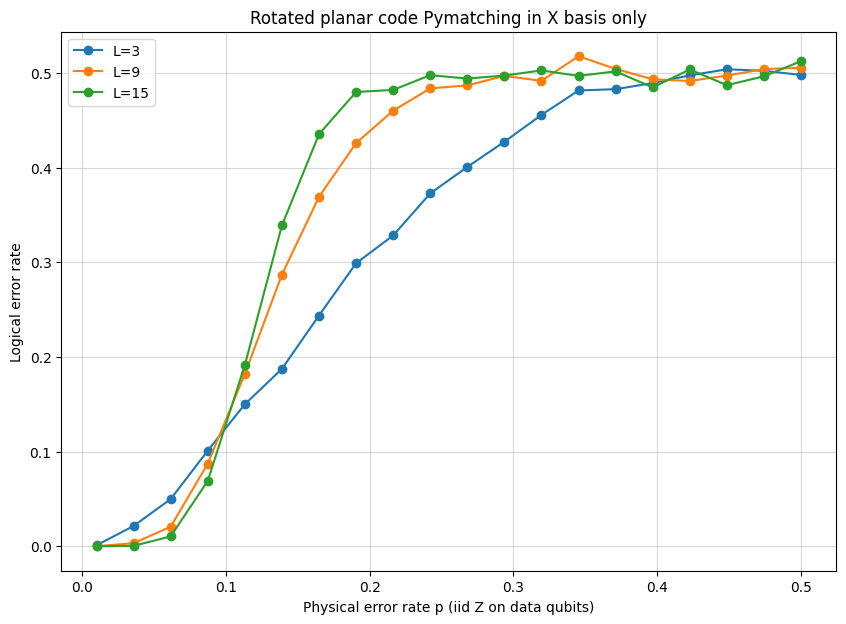

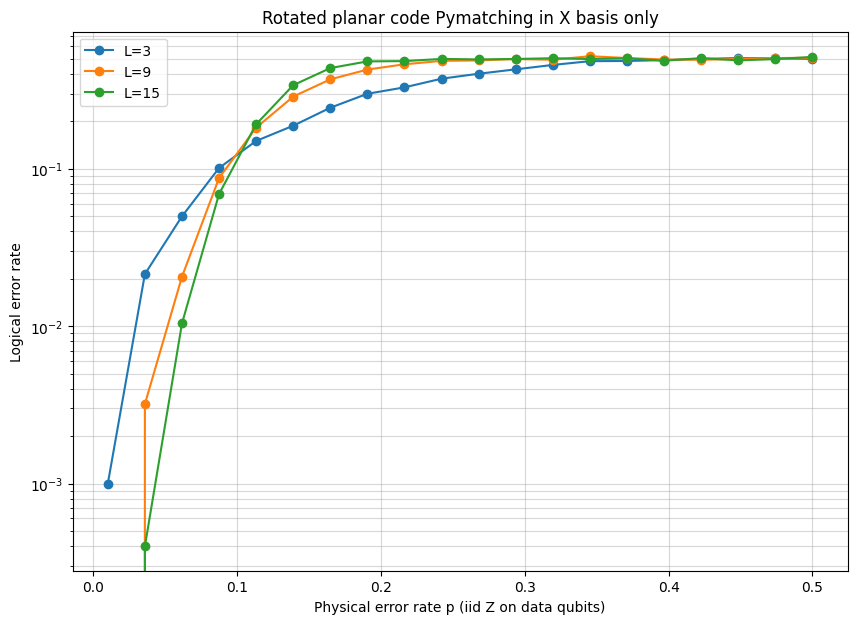

CPU times: user 6.22 s, sys: 182 ms, total: 6.4 s
Wall time: 6.99 s


In [7]:
%%time

from pathlib import Path
from time import perf_counter
import sys

import numpy as np
import matplotlib.pyplot as plt

# Ensure project root is importable when running from repo root or sim/
cwd = Path.cwd().resolve()
candidate_roots = [cwd, *cwd.parents]
project_root = next((p for p in candidate_roots if (p / "parity_checks.py").exists()), cwd)
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from decoders.pymatching_decoder import num_decoding_failures_vectorised
from parity_checks import create_H
from logicals import create_logical, create_logical_2

# --- Simulation Settings ---
num_shots = 5000
Ls = range(3, 21, 6)
ps = np.linspace(0.01, 0.5, 20)

np.random.seed(12345)
log_errors_all_L = []
timing_rows = []

print(
    f"Starting Hx-only simulation (decode Z errors) with {num_shots} shots per point..."
)

for L in Ls:
    print(f"Simulating L={L}...")

    # Hx: X-check matrix; used to decode Z errors (matches toric-code example convention)
    t0 = perf_counter()
    Hx = create_H(L, "x")
    hx_time_s = perf_counter() - t0

    t0 = perf_counter()
    logicals = create_logical(L, "x")  # Z logical observable(s)
    logical_time_s = perf_counter() - t0

    log_errors = []
    decode_time_s = 0.0
    for p in ps:
        t0 = perf_counter()
        num_errors = num_decoding_failures_vectorised(Hx, logicals, p, num_shots)
        decode_time_s += perf_counter() - t0
        log_errors.append(num_errors / num_shots)

    log_errors_all_L.append(np.array(log_errors))
    total_time_s = hx_time_s + logical_time_s + decode_time_s
    timing_rows.append((L, hx_time_s, logical_time_s, decode_time_s, total_time_s))
    print(
        f"  timings (s): Hx={hx_time_s:.4f}, logical={logical_time_s:.4f}, "
        f"decode={decode_time_s:.4f}, total={total_time_s:.4f}"
    )

print("\nTiming summary per L:")
for L, hx_s, logical_s, decode_s, total_s in timing_rows:
    print(
        f"L={L}: Hx={hx_s:.4f}s, logical={logical_s:.4f}s, "
        f"decode={decode_s:.4f}s, total={total_s:.4f}s"
    )

# --- Plotting ---
plt.figure(figsize=(10, 7))
for L, logical_errors in zip(Ls, log_errors_all_L):
    plt.plot(ps, logical_errors, "o-", label=f"L={L}")

plt.xlabel("Physical error rate p (iid Z on data qubits)")
plt.ylabel("Logical error rate")
plt.title("Rotated planar code Pymatching in X basis only")
plt.grid(which="both", alpha=0.5)
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
for L, logical_errors in zip(Ls, log_errors_all_L):
    plt.semilogy(ps, logical_errors, "o-", label=f"L={L}")

plt.xlabel("Physical error rate p (iid Z on data qubits)")
plt.ylabel("Logical error rate")
plt.title("Rotated planar code Pymatching in X basis only")
plt.grid(which="both", alpha=0.5)
plt.legend()
plt.show()


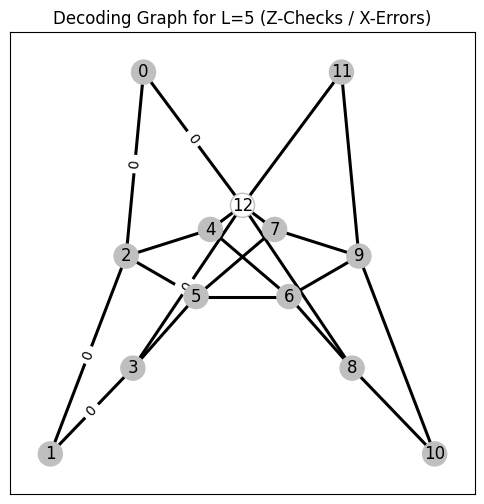

num edges: 21
example edge: (0, 12) attrs: {'fault_ids': {0}, 'weight': 2.1972245773362196, 'error_probability': -1.0}
unique weights (first few): [2.1972245773362196]
fault_ids set sizes: {np.int64(0): np.int64(16), np.int64(1): np.int64(5)}


In [36]:
from logicals import create_logical
from parity_checks import create_H
import numpy as np
from pymatching import Matching


import matplotlib.pyplot as plt
import networkx as nx

# 1. Create a small instance (L=3 is best for debugging)
L = 5
Hx = create_H(L, "x")  # Or your specific H matrix function
Z_L = create_logical(L, "z")

# 2. Initialize Matching object
matching = Matching.from_check_matrix(Hx, faults_matrix=Z_L)

# 3. Draw the graph
plt.figure(figsize=(6, 6))
matching.draw()
plt.title(f"Decoding Graph for L={L} (Z-Checks / X-Errors)")
plt.show()


from pymatching import Matching
import numpy as np

p = 0.1
w = np.full(Hx.shape[1], np.log((1 - p) / p), dtype=float)

m = Matching.from_check_matrix(
    Hx, faults_matrix=Z_L, weights = w
)  # weights default to 1.0 :contentReference[oaicite:5]{index=5}

edges = m.edges()  # list of (u, v, attr) :contentReference[oaicite:6]{index=6}
print("num edges:", len(edges))

# What do attrs look like?
u, v, attr = edges[0]
print(
    "example edge:", (u, v), "attrs:", attr
)  # attr has fault_ids, weight, error_probability :contentReference[oaicite:7]{index=7}

# How many edges go to boundary? (PyMatching uses a boundary node internally; exact representation varies)
weights = [e[2].get("weight", None) for e in edges]
print("unique weights (first few):", sorted(set(weights))[:10])

# Check fault_ids distribution (should be sets of ints; with faults_matrix it can be empty or multi-id too)
sizes = [len(e[2]["fault_ids"]) for e in edges]
print("fault_ids set sizes:", dict(zip(*np.unique(sizes, return_counts=True))))

In [ ]:
import numpy as np


def print_dense(H, name, max_L=5):
    m, n = H.shape
    if n > max_L**2:
        print(f"{name}: too big to dense-print safely (shape={H.shape}).")
        return
    A = H.toarray().astype(int)
    print(f"\n{name}: shape={H.shape}, nnz={H.nnz}")
    print(A)


In [ ]:
from collections import defaultdict
import numpy as np

def bad_duplicate_groups(H, logical):
    H = H.tocsc()
    z = logical.toarray().ravel() % 2

    groups = defaultdict(list)
    for j in range(H.shape[1]):
        a, b = H.indptr[j], H.indptr[j + 1]
        sig = tuple(H.indices[a:b])
        groups[sig].append(j)

    bad = []
    for sig, cols in groups.items():
        if len(cols) > 1:
            vals = {int(z[c]) for c in cols}
            if len(vals) > 1:
                bad.append((sig, cols, vals))
    return bad


L = 5
Hx = create_H(L, "x")
Z_L = create_logical_2(L, "z") 

bad = bad_duplicate_groups(Hx, Z_L)
print("bad groups:", len(bad))
if bad:
    print("example:", bad[0])


bad groups: 1
example: ((np.int32(1),), [2, 5], {0, 1})


In [50]:
print(print_dense(Hx,"test", 5))



test: shape=(12, 25), nnz=40
[[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]]
None
